# Segmentación de cerebro

## Imports

### Instalación de librerías

In [1]:
!pip install monai nibabel torch torchvision

### Llamado de librerías

In [5]:
import monai
print(monai.__version__)

1.5.0


In [7]:
import os
import glob
import torch
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    ToTensord, RandFlipd, RandRotate90d
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference

Nota:
AddChanneld -> EnsureChannelFirstd
Fuente: https://github.com/Project-MONAI/MONAI/discussions/8147


## Lectura de los datos

In [22]:
data_dir_t1 = 'datosparaentrenar/T1-freesurfer'
data_dir_seg = 'datosparaentrenar/aparc-aseg'
t1_paths = sorted(glob.glob(os.path.join(data_dir_t1, '*.nii.gz')))
seg_paths = sorted(glob.glob(os.path.join(data_dir_seg, '*.nii.gz')))

# Crear lista de diccionarios para MONAI
data_dicts = [{'image': img, 'label': seg} for img, seg in zip(t1_paths, seg_paths)]

#### Verifico que se hayan leido bien los datos


In [23]:
print(f"Número de estudios: {len(data_dicts)}")
print("Primer ejemplo:")
print(data_dicts[0])

Número de estudios: 10
Primer ejemplo:
{'image': 'datosparaentrenar/T1-freesurfer\\1301-T1.nii.gz', 'label': 'datosparaentrenar/aparc-aseg\\1301-aparcaseg-label.nii.gz'}


## Preparación de los dataset

In [24]:
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    ScaleIntensityd(keys=['image']),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=0),
    RandRotate90d(keys=['image', 'label'], prob=0.5, spatial_axes=(0, 1)),
    ToTensord(keys=['image', 'label'])
])


train_ds = Dataset(data=data_dicts, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)

### Visualización

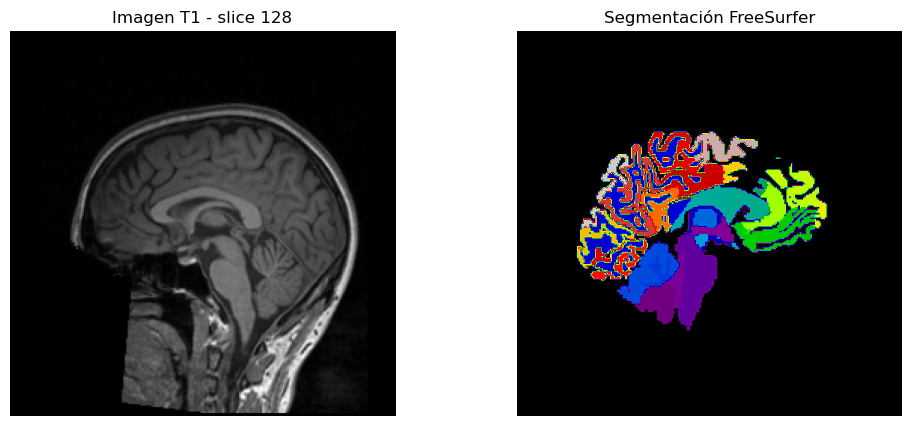

In [30]:
import matplotlib.pyplot as plt

def mostrar_slice(batch_data, slice_index=None):
    image = batch_data["image"][0, 0].cpu().numpy()  # [B, C, D, H, W]
    label = batch_data["label"][0, 0].cpu().numpy()

    if slice_index is None:
        slice_index = image.shape[0] // 2

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image[slice_index], cmap="gray")
    plt.title(f"Imagen T1 - slice {slice_index}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(label[slice_index], cmap="nipy_spectral")
    plt.title("Segmentación FreeSurfer")
    plt.axis("off")

    plt.show()

# 🔍 Usar
batch_data = next(iter(train_loader))
mostrar_slice(batch_data)

#### chequeo

In [26]:
# Tomar la primera muestra y aplicar transformaciones
sample = train_ds[0]

print(f"Tipo de sample: {type(sample)}")
print(f"Keys: {sample.keys()}")

print(f"Shape de imagen: {sample['image'].shape}")
print(f"Shape de etiqueta: {sample['label'].shape}")

print(f"Tipo de dato imagen: {sample['image'].dtype}")
print(f"Tipo de dato etiqueta: {sample['label'].dtype}")

print(f"Shape de imagen y etiqueta deben coincidir: {sample['image'].shape == sample['label'].shape}")

# Opcional: mostrar min y max para comprobar intensidad y etiquetas
print(f"Imagen - min: {sample['image'].min()}, max: {sample['image'].max()}")
print(f"Etiqueta - min: {sample['label'].min()}, max: {sample['label'].max()}")

Tipo de sample: <class 'dict'>
Keys: dict_keys(['image', 'label'])
Shape de imagen: torch.Size([1, 256, 256, 256])
Shape de etiqueta: torch.Size([1, 256, 256, 256])
Tipo de dato imagen: torch.float32
Tipo de dato etiqueta: torch.float32
Shape de imagen y etiqueta deben coincidir: True
Imagen - min: 0.0, max: 1.0
Etiqueta - min: 0.0, max: 109.0


## Configuración, definición del modelo

In [27]:
# Definir modelo, loss, optimizador y métricas
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=110,  # cuento 109 segmentos + 1 fondo
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")


## Entrenamiento

In [28]:
max_epochs = 5
model.train()

for epoch in range(max_epochs):
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{max_epochs}, Loss: {epoch_loss/step:.4f}")

Epoch 1/5, Loss: 0.9980
Epoch 2/5, Loss: 0.9962
Epoch 3/5, Loss: 0.9931
Epoch 4/5, Loss: 0.9883
Epoch 5/5, Loss: 0.9838


## Guardar modelo

In [29]:
torch.save(model.state_dict(), "simple_cnn3d_segmentation.pth")

## Test

## Visualización